In [3]:
import os
import math
import pickle
import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from dataloaders import random_collapse_per_path, PartialMergingTaxonomyDataset
from torch.utils.data import random_split

os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"] = "1"

from datasets import Dataset as HFDataset
from transformers import DataCollatorForLanguageModeling, BatchEncoding
from dataloaders import dataset_to_hf_dataset, TaxonomyPreCollator, create_taxonomy_data_collator

/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# def create_taxonomy_data_collator(token_dict, mlm_probability=0.15, mask_replace_prob=1):
#     pre_collator = TaxonomyPreCollator(token_dict)
#     mlm_collator = DataCollatorForLanguageModeling(
#         tokenizer=pre_collator, 
#         mlm=True, 
#         mlm_probability=mlm_probability,
#         mask_replace_prob=mask_replace_prob,
#         random_replace_prob=0
#     )
#     return mlm_collator


In [5]:
import random
import torch
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load Data

In [6]:
# Adjust these paths as needed
taxonomy_matrix_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-taxonomy-matrix.npz"
taxonomy_mapping_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/taxonomy_mapping.csv"

# Load the sparse (samples x taxonomies) matrix
X_taxonomy = sp.load_npz(taxonomy_matrix_path)
print("X_taxonomy shape:", X_taxonomy.shape)

# Load the mapping of columns -> taxonomy strings
df_tax_mapping = pd.read_csv(taxonomy_mapping_path)
taxonomy_list = df_tax_mapping["taxonomy"].tolist()

# print("Number of taxonomies:", len(taxonomy_list))
# print("First 5 taxonomies:", taxonomy_list[:5])


## dataloader
output_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/taxonomy_token_dictionary.pkl"
with open(output_path, "rb") as f:
    token_dict = pickle.load(f)
print("Loaded token dictionary with size:", len(token_dict))
do_augmentation=False
# Use your dynamic PyTorch dataset directly
partial_dataset = PartialMergingTaxonomyDataset(
    X_taxonomy=X_taxonomy,
    taxonomy_list=taxonomy_list,
    token_dict=token_dict,
    max_taxa=104,
    possible_ranks=('p','c','o','f','g','s'),
    do_augmentation=do_augmentation  # dynamic augmentation enabled
)

# Assume partial_dataset is your instance of PartialMergingTaxonomyDataset
total_samples = len(partial_dataset)
val_size = int(0.2 * total_samples)
train_size = total_samples - val_size


g = torch.Generator().manual_seed(123)
train_dataset, val_dataset = random_split(partial_dataset, [train_size, val_size], generator=g)

print(f"Total samples: {total_samples}")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


original_val_size = len(val_dataset)
small_val_size = 1000#original_val_size // 2
test_size = original_val_size - small_val_size

# Split validation dataset into small val and test datasets
val_dataset, test_dataset = random_split(
    val_dataset, [small_val_size, test_size], generator=torch.Generator().manual_seed(123)
)

print(f"Original validation size: {original_val_size}")
print(f"Small validation dataset size (for periodic eval): {len(val_dataset)}")
print(f"Test dataset size (final evaluation): {len(test_dataset)}")

X_taxonomy shape: (1836255, 8533)
Loaded token dictionary with size: 11318
Total samples: 1836255
Train samples: 1469004
Validation samples: 367251
Original validation size: 367251
Small validation dataset size (for periodic eval): 1000
Test dataset size (final evaluation): 366251


In [7]:
367251*0.1

36725.1

In [8]:
def compute_custom_metrics(eval_pred):
    predictions, labels = eval_pred

    # predictions: (batch_size, seq_len, vocab_size)
    # labels: (batch_size, seq_len)
    pred_ids = predictions.argmax(-1)

    total_masked, correct, total_repeated = 0, 0, 0
    batch_repetition_fractions = []

    for pred, label in zip(pred_ids, labels):
        masked_positions = (label != -100)
        true_tokens = label[masked_positions]
        predicted_tokens = pred[masked_positions]

        total_masked += len(true_tokens)
        correct += (predicted_tokens == true_tokens).sum().item()

        # Compute repetition fraction per sample
        predicted_tokens_tensor = torch.tensor(predicted_tokens)
        unique_preds = len(torch.unique(predicted_tokens_tensor))
        
        repetition_fraction = (
            (len(predicted_tokens) - unique_preds) / len(predicted_tokens)
            if len(predicted_tokens) > 0 else 0.0
        )
        batch_repetition_fractions.append(repetition_fraction)
        total_repeated += len(predicted_tokens) - unique_preds

    accuracy = correct / total_masked if total_masked else 0
    mean_repetition = np.mean(batch_repetition_fractions)

    return {
        "accuracy": accuracy,
        "mean_repetition": mean_repetition,
        "total_masked": total_masked,
        "total_repeated": total_repeated
    }


In [15]:
from transformers import TrainerCallback

class LogTrainBatchMetricsCallback(TrainerCallback):
    def __init__(self, compute_metrics_fn, trainer_ref):
        self.compute_metrics_fn = compute_metrics_fn
        self.trainer = trainer_ref

    def on_evaluate(self, args, state, control, **kwargs):
        print(f"\n🧪 Evaluating on current training batch at step {state.global_step}...")

        # Get a batch from the train dataloader
        train_dataloader = self.trainer.get_train_dataloader()
        try:
            train_batch = next(iter(train_dataloader))
        except StopIteration:
            print("⚠️ Could not retrieve a training batch.")
            return

        # Move batch to device
        device = self.trainer.model.device
        batch = {k: v.to(device) for k, v in train_batch.items()}

        # Forward pass
        with torch.no_grad():
            outputs = self.trainer.model(**batch)

        logits = outputs.logits
        labels = batch["labels"]

        # Compute metrics
        metrics = self.compute_metrics_fn((logits.cpu().numpy(), labels.cpu().numpy()))
        metrics = {f"train_batch_{k}": v for k, v in metrics.items()}

        # Log to Trainer
        if self.trainer.is_world_process_zero():
            self.trainer.log(metrics)

# trainer

In [16]:
from pretrainer import TaxonomyPretrainer, SaveEveryNEpochsCallback
from transformers import (
    BertConfig, 
    BertForMaskedLM, 
    TrainingArguments, 
    Trainer
)
from transformers import TrainerCallback, TrainerState, TrainerControl

In [17]:

# if do_augmentation==False:
#     save_model_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/"
# else:
#     save_model_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs/"
#save_model_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs_no_randon_replace/"


if do_augmentation==False:
    save_model_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_with_metrics/"
else:
    save_model_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_with_metrics/"

vocab_size = len(token_dict)  # token_dict includes <pad>, <mask>, etc.
print(vocab_size)


config = BertConfig(
    vocab_size=vocab_size,
    hidden_size=256,        # embedding dim
    num_hidden_layers=6,    # number of Transformer layers
    num_attention_heads=4,
    max_position_embeddings=128,  # or your max sequence length
    pad_token_id=token_dict["<pad>"],
)
model = BertForMaskedLM(config)

# # 2) Build training arguments
# training_args = TrainingArguments(
#     output_dir=save_model_path,
#     overwrite_output_dir=True,
#     num_train_epochs=50,
#     per_device_train_batch_size=256,  # 64*4, for example
#     learning_rate=1e-4,
#     logging_steps=1000,
#     save_strategy="no",       #  using the callback instead
#     eval_strategy="no",
# )

training_args = TrainingArguments(
    output_dir=save_model_path,
    overwrite_output_dir=True,
    num_train_epochs=40 ,#50,
    per_device_train_batch_size=256,
    learning_rate=1e-4,
    logging_steps=1000,
    save_strategy="epoch",           # Automatically saves every epoch
    eval_strategy="steps",
    eval_steps=1000,                 # Evaluate every 1000 steps
    logging_strategy="steps",
    logging_dir=f"{save_model_path}/logs",
)

11318


In [18]:
# 3) data collator (the one you tested)
collator = create_taxonomy_data_collator(token_dict)

# 4) Build the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collator,
    compute_metrics=compute_custom_metrics,
    #callbacks=[SaveEveryNEpochsCallback(save_every=5, output_dir=save_model_path)]
)
trainer.add_callback(LogTrainBatchMetricsCallback(
    compute_metrics_fn=compute_custom_metrics,
    trainer_ref=trainer
))
# 5) Train
trainer.train()
trainer.save_model(save_model_path)


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Mean Repetition,Total Masked,Total Repeated
1000,6.278100,5.337244,0.153964,0.429037,5222,3172
2000,5.258200,4.969666,0.168500,0.417030,5365,3175
3000,5.026900,4.830101,0.177875,0.401417,5279,3052
4000,4.906800,4.733644,0.176798,0.408635,5215,2995
5000,4.821800,4.593983,0.181015,0.401981,5204,2985
6000,4.762800,4.602214,0.181527,0.411016,5305,3045
7000,4.709500,4.546239,0.185414,0.406600,5334,3050
8000,4.669300,4.457867,0.194107,0.393278,5193,2945
9000,4.631900,4.441955,0.186597,0.396597,5193,2898
10000,4.598800,4.407144,0.202191,0.394948,5203,2889



🧪 Evaluating on current training batch at step 1000...

🧪 Evaluating on current training batch at step 2000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 3000...

🧪 Evaluating on current training batch at step 4000...

🧪 Evaluating on current training batch at step 5000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 6000...

🧪 Evaluating on current training batch at step 7000...

🧪 Evaluating on current training batch at step 8000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 9000...

🧪 Evaluating on current training batch at step 10000...

🧪 Evaluating on current training batch at step 11000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 12000...

🧪 Evaluating on current training batch at step 13000...

🧪 Evaluating on current training batch at step 14000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 15000...

🧪 Evaluating on current training batch at step 16000...

🧪 Evaluating on current training batch at step 17000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 18000...

🧪 Evaluating on current training batch at step 19000...

🧪 Evaluating on current training batch at step 20000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 21000...

🧪 Evaluating on current training batch at step 22000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 23000...

🧪 Evaluating on current training batch at step 24000...

🧪 Evaluating on current training batch at step 25000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 26000...

🧪 Evaluating on current training batch at step 27000...

🧪 Evaluating on current training batch at step 28000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 29000...

🧪 Evaluating on current training batch at step 30000...

🧪 Evaluating on current training batch at step 31000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 32000...

🧪 Evaluating on current training batch at step 33000...

🧪 Evaluating on current training batch at step 34000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 35000...

🧪 Evaluating on current training batch at step 36000...

🧪 Evaluating on current training batch at step 37000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 38000...

🧪 Evaluating on current training batch at step 39000...

🧪 Evaluating on current training batch at step 40000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 41000...

🧪 Evaluating on current training batch at step 42000...

🧪 Evaluating on current training batch at step 43000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 44000...

🧪 Evaluating on current training batch at step 45000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 46000...

🧪 Evaluating on current training batch at step 47000...

🧪 Evaluating on current training batch at step 48000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 49000...

🧪 Evaluating on current training batch at step 50000...

🧪 Evaluating on current training batch at step 51000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 52000...

🧪 Evaluating on current training batch at step 53000...

🧪 Evaluating on current training batch at step 54000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 55000...

🧪 Evaluating on current training batch at step 56000...

🧪 Evaluating on current training batch at step 57000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 58000...

🧪 Evaluating on current training batch at step 59000...

🧪 Evaluating on current training batch at step 60000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 61000...

🧪 Evaluating on current training batch at step 62000...

🧪 Evaluating on current training batch at step 63000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 64000...

🧪 Evaluating on current training batch at step 65000...

🧪 Evaluating on current training batch at step 66000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 67000...

🧪 Evaluating on current training batch at step 68000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 69000...

🧪 Evaluating on current training batch at step 70000...

🧪 Evaluating on current training batch at step 71000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 72000...

🧪 Evaluating on current training batch at step 73000...

🧪 Evaluating on current training batch at step 74000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 75000...

🧪 Evaluating on current training batch at step 76000...

🧪 Evaluating on current training batch at step 77000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 78000...

🧪 Evaluating on current training batch at step 79000...

🧪 Evaluating on current training batch at step 80000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 81000...

🧪 Evaluating on current training batch at step 82000...

🧪 Evaluating on current training batch at step 83000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 84000...

🧪 Evaluating on current training batch at step 85000...

🧪 Evaluating on current training batch at step 86000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 87000...

🧪 Evaluating on current training batch at step 88000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 89000...

🧪 Evaluating on current training batch at step 90000...

🧪 Evaluating on current training batch at step 91000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 92000...

🧪 Evaluating on current training batch at step 93000...

🧪 Evaluating on current training batch at step 94000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 95000...

🧪 Evaluating on current training batch at step 96000...

🧪 Evaluating on current training batch at step 97000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 98000...

🧪 Evaluating on current training batch at step 99000...

🧪 Evaluating on current training batch at step 100000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 101000...

🧪 Evaluating on current training batch at step 102000...

🧪 Evaluating on current training batch at step 103000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 104000...

🧪 Evaluating on current training batch at step 105000...

🧪 Evaluating on current training batch at step 106000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 107000...

🧪 Evaluating on current training batch at step 108000...

🧪 Evaluating on current training batch at step 109000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 110000...

🧪 Evaluating on current training batch at step 111000...


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🧪 Evaluating on current training batch at step 112000...

🧪 Evaluating on current training batch at step 113000...

🧪 Evaluating on current training batch at step 114000...


In [20]:
save_model_path

'/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_with_metrics/'

In [21]:
import json
import matplotlib.pyplot as plt

path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_with_metrics/checkpoint-114800/trainer_state.json"
with open(path, "r") as f:
    trainer_state = json.load(f)

logs = trainer_state["log_history"]


In [24]:
steps = []
train_loss = []
val_loss = []
val_acc = []
val_rep = []
train_acc = []
train_rep = []

for log in logs:
    if "loss" in log:
        train_loss.append(log["loss"])
        steps.append(log["step"])
    if "eval_loss" in log:
        val_loss.append(log["eval_loss"])
    if "eval_accuracy" in log:
        val_acc.append(log["eval_accuracy"])
    if "eval_mean_repetition" in log:
        val_rep.append(log["eval_mean_repetition"])
    if "train_batch_accuracy" in log:
        train_acc.append(log["train_batch_accuracy"])
    if "train_batch_mean_repetition" in log:
        train_rep.append(log["train_batch_mean_repetition"])


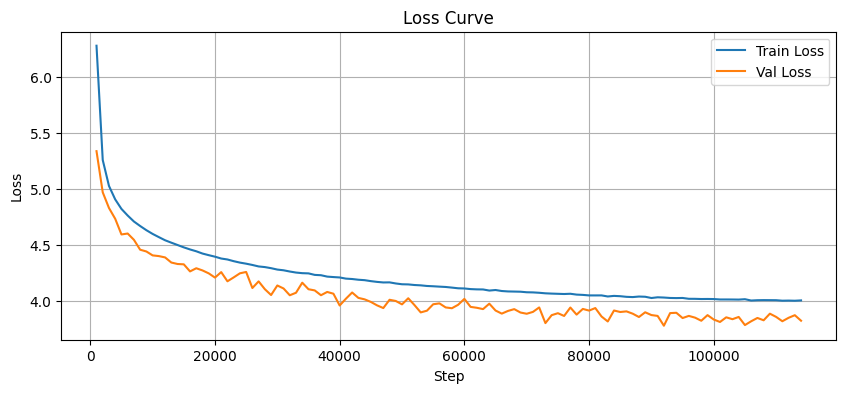

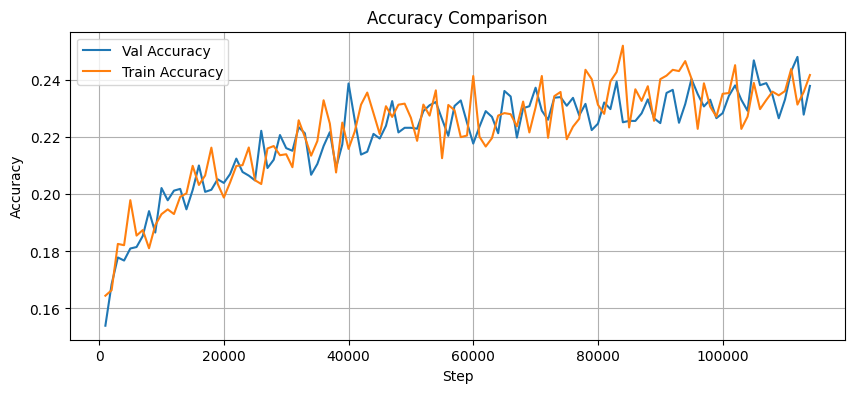

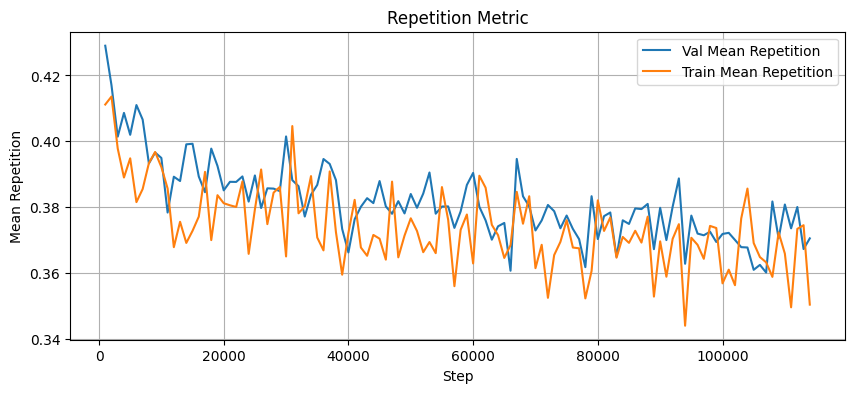

In [25]:
# Plot losses
plt.figure(figsize=(10, 4))
plt.plot(steps, train_loss, label="Train Loss")
if val_loss: plt.plot(steps, val_loss, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
if val_acc and train_acc:
    plt.figure(figsize=(10, 4))
    plt.plot(steps, val_acc, label="Val Accuracy")
    plt.plot(steps, train_acc, label="Train Accuracy")
    plt.title("Accuracy Comparison")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot repetition
if val_rep and train_rep:
    plt.figure(figsize=(10, 4))
    plt.plot(steps, val_rep, label="Val Mean Repetition")
    plt.plot(steps, train_rep, label="Train Mean Repetition")
    plt.title("Repetition Metric")
    plt.xlabel("Step")
    plt.ylabel("Mean Repetition")
    plt.legend()
    plt.grid(True)
    plt.show()


In [31]:

id_to_str = {v: k for k, v in token_dict.items()}

sample_index = 3
sample = val_dataset[sample_index]

collator = create_taxonomy_data_collator(token_dict)
batch: BatchEncoding = collator([sample])

# Extract masked input_ids and labels
masked_ids = batch["input_ids"][0]
labels = batch["labels"][0]

# Positions masked (where labels are not -100)
masked_positions = (labels != -100).nonzero(as_tuple=True)[0].tolist()

# Run model inference on the masked sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

input_ids_tensor = masked_ids.unsqueeze(0).to(device)  # Add batch dimension
attention_mask_tensor = (input_ids_tensor != token_dict["<pad>"]).long()

with torch.no_grad():
    outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
    logits = outputs.logits  # [1, seq_len, vocab_size]

# Print detailed vertical inspection
original_ids = sample["input_ids"]

print("\n=== Detailed Sample Inspection (Sample index {}) ===".format(sample_index))
for pos in range(len(original_ids)):
    orig_tok = original_ids[pos]
    orig_str = id_to_str.get(orig_tok, "<unk>")

    if pos in masked_positions:
        true_label = labels[pos].item()
        true_label_str = id_to_str.get(true_label, "<unk>")

        token_logits = logits[0, pos]
        topk = torch.topk(token_logits, k=5)
        top_ids = topk.indices.tolist()
        top_values = topk.values.tolist()
        top_preds = [id_to_str.get(tid, "<unk>") for tid in top_ids]

        print(f"Position {pos}:")
        print(f"  Original Token: {orig_tok} => {orig_str} [MASKED]")
        #print(f"  Label (true masked token): {true_label} => {true_label_str}")
        print("  Top-5 Predictions:")
        for rank, (pred_id, score, pred_str) in enumerate(zip(top_ids, top_values, top_preds), 1):
            print(f"    {rank}. {pred_id} => {pred_str}, logit: {score:.2f}")
    else:
        print(f"Position {pos}: {orig_tok} => {orig_str}")
        if orig_str == "<pad>":
            break


=== Detailed Sample Inspection (Sample index 3) ===
Position 0: 715 => d__Bacteria
Position 1: 8144 => d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria
Position 2: 10385 => d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiomicrospirales
Position 3: 7994 => d__Bacteria;p__Planctomycetota;c__Phycisphaerae;o__Phycisphaerales;f__SM1A02
Position 4: 5792 => d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus
Position 5:
  Original Token: 8083 => d__Bacteria;p__Planctomycetota;c__Planctomycetes;o__Pirellulales;f__UBA1268;g__UBA1268;s__UBA1268 [MASKED]
  Top-5 Predictions:
    1. 8083 => d__Bacteria;p__Planctomycetota;c__Planctomycetes;o__Pirellulales;f__UBA1268;g__UBA1268;s__UBA1268, logit: 15.44
    2. 9865 => d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Pasteurellaceae, logit: 7.59
    3. 9156 => d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria, logit: 7.28
    4. 10147 => d__Bacteria

In [32]:

id_to_str = {v: k for k, v in token_dict.items()}

sample_index = 4
sample = val_dataset[sample_index]

collator = create_taxonomy_data_collator(token_dict)
batch: BatchEncoding = collator([sample])

# Extract masked input_ids and labels
masked_ids = batch["input_ids"][0]
labels = batch["labels"][0]

# Positions masked (where labels are not -100)
masked_positions = (labels != -100).nonzero(as_tuple=True)[0].tolist()

# Run model inference on the masked sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

input_ids_tensor = masked_ids.unsqueeze(0).to(device)  # Add batch dimension
attention_mask_tensor = (input_ids_tensor != token_dict["<pad>"]).long()

with torch.no_grad():
    outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
    logits = outputs.logits  # [1, seq_len, vocab_size]

# Print detailed vertical inspection
original_ids = sample["input_ids"]

print("\n=== Detailed Sample Inspection (Sample index {}) ===".format(sample_index))
for pos in range(len(original_ids)):
    orig_tok = original_ids[pos]
    orig_str = id_to_str.get(orig_tok, "<unk>")

    if pos in masked_positions:
        true_label = labels[pos].item()
        true_label_str = id_to_str.get(true_label, "<unk>")

        token_logits = logits[0, pos]
        topk = torch.topk(token_logits, k=5)
        top_ids = topk.indices.tolist()
        top_values = topk.values.tolist()
        top_preds = [id_to_str.get(tid, "<unk>") for tid in top_ids]

        print(f"Position {pos}:")
        print(f"  Original Token: {orig_tok} => {orig_str} [MASKED]")
        #print(f"  Label (true masked token): {true_label} => {true_label_str}")
        print("  Top-5 Predictions:")
        for rank, (pred_id, score, pred_str) in enumerate(zip(top_ids, top_values, top_preds), 1):
            print(f"    {rank}. {pred_id} => {pred_str}, logit: {score:.2f}")
    else:
        print(f"Position {pos}: {orig_tok} => {orig_str}")
        if orig_str == "<pad>":
            break


=== Detailed Sample Inspection (Sample index 4) ===
Position 0: 8694 => d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Amylibacter_A;s__Amylibacter_A
Position 1: 627 => d__Archaea;p__Thermoplasmatota;c__Poseidoniia;o__Poseidoniales;f__Poseidoniaceae;g__MGIIa-L1;s__MGIIa-L1
Position 2: 2213 => d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__TMED189;f__TMED189;g__TMED189;s__TMED189
Position 3: 8680 => d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae
Position 4: 9690 => d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Ectothiorhodospirales
Position 5: 3377 => d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae
Position 6: 4436 => d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia
Position 7: 11121 => d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae
Position 8: 8314 => d__Bacteria;p__Proteobacteria;c__Alphaproteobacteri

# test

In [26]:
import random
import torch
import math
import re
from transformers import BertForMaskedLM


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [29]:


def randomly_mask_sequence(
    original_ids,
    mask_token_id,
    vocab_size,
    mlm_probability=0.15,
    mask_replace_prob=0.8,
    random_replace_prob=0.1,
    special_ids=None
):
    """
    Randomly mask ~mlm_probability fraction of NON-SPECIAL tokens in original_ids.
    Returns:
      masked_ids        : the new list of token IDs
      masked_positions  : list of indices that got masked
      original_tokens   : same length as masked_ids; only set at masked positions
    """
    if special_ids is None:
        special_ids = set()
    seq_length = len(original_ids)
    masked_ids = original_ids[:]
    masked_positions = []
    original_tokens = [None]*seq_length
    
    # 1) Decide which tokens to mask:
    # only pick positions that are not in special_ids
    candidate_positions = [
        i for i, tok in enumerate(original_ids)
        if tok not in special_ids
    ]
    # number of tokens to mask
    num_to_mask = int(len(candidate_positions) * mlm_probability)
    random.shuffle(candidate_positions)
    chosen_positions = candidate_positions[:num_to_mask]
    
    for pos in chosen_positions:
        original_tok = original_ids[pos]
        masked_positions.append(pos)
        original_tokens[pos] = original_tok  # store the ground truth at pos

        # now pick how we replace it:
        r = random.random()
        if r < mask_replace_prob:
            # replace with <mask>
            masked_ids[pos] = mask_token_id
        elif r < mask_replace_prob + random_replace_prob:
            # replace with a random ID
            rnd_id = random.randint(0, vocab_size - 1)
            masked_ids[pos] = rnd_id
        else:
            # keep original
            masked_ids[pos] = original_tok
    
    return masked_ids, masked_positions, original_tokens


def test_model_on_val_samples_batched(
    model,
    val_dataset,
    token_dict,
    device,
    n=100,
    mlm_probability=0.15,
    batch_size=32,
    seed=123
):
    """
    Evaluate the model on up to 'n' random samples from val_dataset, using a batched approach.
    
    Steps:
      1. Select 'n' samples from val_dataset (randomly).
      2. For each sample, apply random masking (~ mlm_probability) via randomly_mask_sequence.
      3. Collect the masked sequences in a list.
      4. Split that list into batches of 'batch_size'.
      5. For each batch:
         - Pad and convert to tensors (a minimal 'collator' step).
         - Run a single forward pass to get logits.
         - Compute top-1 accuracy for the masked positions in each sample.
    
    Returns:
      overall_accuracy: float   (top-1 masked token accuracy across all masked positions)
      examples_list: list of dicts with info per sample:
         - "original_ids":    the original token IDs
         - "masked_ids":      the masked sequence
         - "masked_positions": positions that were masked
         - "original_tokens": ground-truth token IDs at those masked positions
         - "logits":          a list-of-lists with shape [seq_len, vocab_size], 
         - "sample_idx":      the index in val_dataset
    """
    # Make the model ready for inference
    model.eval()
    model.to(device)
    
    # For reproducible sample selection
    random.seed(seed)
    
    # 1) Choose up to n random samples from val_dataset
    indices = list(range(len(val_dataset)))
    random.shuffle(indices)
    chosen_indices = indices[:n]
    
    pad_id = token_dict["<pad>"]
    mask_id = token_dict["<mask>"]
    vocab_size = len(token_dict)
    
    # We'll skip special tokens from masking
    special_ids = {pad_id, mask_id}
    
    # 2) For each chosen sample, apply random masking
    #    We'll store the results for later batching
    all_masked_data = []  # each entry: (masked_ids, masked_positions, original_tokens, orig_ids, sample_idx)
    
    total_samples_used = 0
    for idx in chosen_indices:
        row = val_dataset[idx]
        original_ids = row["input_ids"]
        
        masked_ids, masked_positions, original_tokens = randomly_mask_sequence(
            original_ids,
            mask_token_id=mask_id,
            vocab_size=vocab_size,
            mlm_probability=mlm_probability,
            special_ids=special_ids
        )
        
        if len(masked_positions) == 0:
            continue
        
        # Save the masked data
        all_masked_data.append((masked_ids, masked_positions, original_tokens, original_ids, idx))
        total_samples_used += 1
    
    if total_samples_used == 0:
        return 0.0, []  # No masked tokens => accuracy = 0
    
    # 3) Build results containers
    total_masked_tokens = 0
    correct_top1 = 0
    examples_list = []
    
    # 4) Split the masked data into mini-batches
    num_batches = math.ceil(len(all_masked_data) / batch_size)
    
    start_idx = 0
    for b in range(num_batches):
        batch_data = all_masked_data[start_idx : start_idx + batch_size]
        start_idx += batch_size
        
        # A) Collect masked sequences for this batch
        batch_masked_ids   = [dat[0] for dat in batch_data]  # list of masked_id lists
        batch_positions    = [dat[1] for dat in batch_data]
        batch_orig_tokens  = [dat[2] for dat in batch_data]
        batch_original_ids = [dat[3] for dat in batch_data]
        batch_sample_idx   = [dat[4] for dat in batch_data]
        
        # B) Pad them (manually or with a minimal collator)
        max_len = max(len(seq) for seq in batch_masked_ids)
        
        padded_input_ids = []
        attention_masks  = []
        for seq in batch_masked_ids:
            pad_needed = max_len - len(seq)
            padded_seq = seq + [pad_id]*pad_needed
            padded_input_ids.append(padded_seq)
            attn_mask = [1 if t != pad_id else 0 for t in padded_seq]
            attention_masks.append(attn_mask)
        
        # Convert to tensors
        input_ids_tensor = torch.tensor(padded_input_ids, dtype=torch.long, device=device)
        attention_mask_tensor = torch.tensor(attention_masks, dtype=torch.long, device=device)
        
        # C) Forward pass
        with torch.no_grad():
            outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
            logits_batch = outputs.logits  # shape: [batch_size, max_len, vocab_size]
        
        # D) Evaluate top-1 accuracy for each sample in this batch
        for i in range(len(batch_data)):
            sample_logits = logits_batch[i]  # shape: [max_len, vocab_size]
            masked_positions = batch_positions[i]
            original_tokens  = batch_orig_tokens[i]
            orig_ids         = batch_original_ids[i]
            s_idx            = batch_sample_idx[i]
            
            # Evaluate top-1
            for pos in masked_positions:
                true_id = original_tokens[pos]
                if true_id is None:
                    continue
                total_masked_tokens += 1
                pred_id = torch.argmax(sample_logits[pos]).item()
                if pred_id == true_id:
                    correct_top1 += 1
            
            # Store example info
            example_info = {
                "original_ids":    orig_ids,
                "masked_ids":      batch_masked_ids[i],
                "masked_positions": masked_positions,
                "original_tokens":  original_tokens,
                # Because we padded, 'sample_logits' might have a shape bigger than original seq,
                # but the relevant positions are up to len(masked_ids). We'll store the entire CPU array for now.
                "logits": sample_logits.cpu().tolist(),
                "sample_idx": s_idx
            }
            examples_list.append(example_info)
    
    # Final top-1 masked accuracy
    overall_accuracy = correct_top1 / total_masked_tokens if total_masked_tokens > 0 else 0.0
    
    return overall_accuracy, examples_list



=== Loading checkpoint at epoch 1: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/checkpoint-epoch1 ===
Epoch 1 => Accuracy: 0.1764

=== Loading checkpoint at epoch 5: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/checkpoint-epoch5 ===
Epoch 5 => Accuracy: 0.2103

=== Loading checkpoint at epoch 10: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/checkpoint-epoch10 ===
Epoch 10 => Accuracy: 0.2278

=== Loading checkpoint at epoch 15: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/checkpoint-epoch15 ===
Epoch 15 => Accuracy: 0.2314

=== Loading checkpoint at epoch 20: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/checkpoint-ep

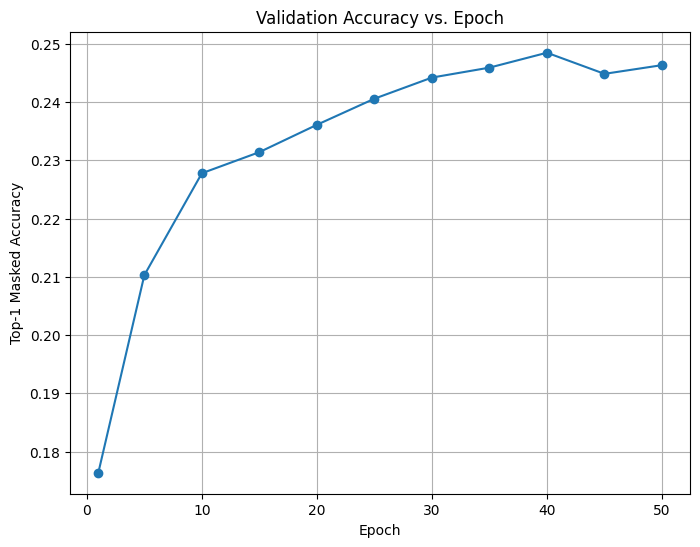

In [31]:

# Path to your model folder
model_folder = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs"

# 1) Gather all checkpoint subfolders
checkpoints = []
for d in os.listdir(model_folder):
    if d.startswith("checkpoint-epoch"):
        checkpoints.append(d)

# Helper function to extract the integer epoch from the folder name, e.g. "checkpoint-epoch5" => 5
def get_epoch_from_dir(dirname):
    # find trailing digits
    match = re.search(r"(\d+)$", dirname)
    if match:
        return int(match.group(1))
    return -1

# Sort the checkpoint directories by epoch number
checkpoints.sort(key=get_epoch_from_dir)

# We'll store (epoch, accuracy)
epochs = []
accuracies = []

# 2) Evaluate each checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for d in checkpoints:
    ep = get_epoch_from_dir(d)
    checkpoint_path = os.path.join(model_folder, d)
    
    print(f"\n=== Loading checkpoint at epoch {ep}: {checkpoint_path} ===")
    
    # Load the model from that checkpoint
    model_ckpt = BertForMaskedLM.from_pretrained(checkpoint_path)
    model_ckpt.to(device)
    
    # 3) Evaluate top-1 masked accuracy on e.g. 1,000 val samples
    accuracy, _ = test_model_on_val_samples_batched(
        model=model_ckpt,
        val_dataset=val_dataset,   # your validation dataset
        token_dict=token_dict,
        device=device,
        n=1000,                   # how many samples to test
        mlm_probability=0.15,
        batch_size=256,
        seed=123
    )
    
    epochs.append(ep)
    accuracies.append(accuracy)
    
    print(f"Epoch {ep} => Accuracy: {accuracy:.4f}")

# 4) Plot the results
plt.figure(figsize=(8,6))
plt.plot(epochs, accuracies, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Top-1 Masked Accuracy")
plt.title("Validation Accuracy vs. Epoch")
plt.grid(True)

In [32]:
accuracy, examples_list = test_model_on_val_samples_batched(
    model_ckpt,
    val_dataset,
    token_dict,
    device=torch.device("cuda"),
    n=1000,
    mlm_probability=0.15,
    batch_size=256,
    seed=123    
)

print("Overall top-1 masked token accuracy:", accuracy)


Overall top-1 masked token accuracy: 0.24632117722328856


In [33]:
for ex_idx, sample_info in enumerate(examples_list[:2]):
    orig_ids = sample_info["original_ids"]
    masked_ids = sample_info["masked_ids"]
    masked_positions = sample_info["masked_positions"]
    original_tokens = sample_info["original_tokens"]
    logits_matrix = sample_info["logits"]  # shape [seq_len, vocab_size]

    print(f"\n=== Example {ex_idx} ===")
    print("original_ids:", orig_ids)
    print("masked_ids:  ", masked_ids)
    print("masked_positions:", masked_positions)

    # Print the top-5 predictions for each masked position
    for pos in masked_positions[:5]:
        true_id = original_tokens[pos]
        true_str = next((k for k,v in token_dict.items() if v==true_id), "<unk>")

        # logits for this position
        token_logits = torch.tensor(logits_matrix[pos])  # shape [vocab_size]
        topk = torch.topk(token_logits, 5)
        top_indices = topk.indices.tolist()
        top_values  = topk.values.tolist()

        print(f"\nPosition {pos}, true token => {true_id} ({true_str})")
        print("Top 5 predictions:")
        for rank, (pred_id, val) in enumerate(zip(top_indices, top_values), start=1):
            pred_str = next((k for k,v in token_dict.items() if v==pred_id), "<unk>")
            print(f"  {rank}: id={pred_id}, logit={val:.2f}, => {pred_str}")



=== Example 0 ===
original_ids: [10014, 8144, 8047, 8049, 8532, 8325, 9156, 4436, 8620, 8680, 3580, 10369, 8432, 715, 2132, 9029, 8442, 4652, 8517, 8444, 4193, 8308, 2200, 8056, 4443, 8086, 8959, 10454, 9724, 4700, 8220, 7118, 8278, 8362, 8083, 10004, 10116, 9074, 11121, 3694, 11055, 8629, 8280, 3419, 2191, 9725, 10154, 7338, 10794, 10433, 8918, 9911, 4739, 7989, 7377, 8281, 9694, 4523, 8503, 4875, 8053, 7331, 3426, 10148, 4565, 8419, 11132, 8075, 8564, 3405, 8518, 1790, 4592, 11120, 8081, 3571, 2071, 8090, 2709, 2193, 7994, 3715, 3758, 3404, 9031, 1995, 8253, 3316, 8880, 4471, 3377, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
masked_ids:   [10014, 8144, 8047, 8049, 8532, 8325, 9156, 4436, 8620, 8680, 1, 10369, 8432, 715, 2132, 9029, 1, 4652, 8517, 8444, 4193, 1, 2200, 1, 4443, 8086, 8959, 10454, 9724, 4700, 8220, 7118, 8278, 1, 8083, 10004, 10116, 9074, 11121, 3694, 11055, 8629, 8280, 3419, 2191, 9725, 10154, 1, 10794, 10433, 8918, 9911, 4739, 7989, 1, 8281, 9694, 1, 8503, 1, 1, 7331, 342

In [10]:
# Assume:
# - examples_list is returned by test_model_on_val_samples(...)
# - id_to_str is a dictionary mapping token IDs to taxonomy strings (constructed as below)

# Build the inverse dictionary for convenience:
id_to_str = {v: k for k, v in token_dict.items()}

# Let's inspect the first sample (you can loop over multiple if desired)
if len(examples_list) > 0:
    sample_info = examples_list[0]
    orig_ids = sample_info["original_ids"]  # Original token IDs (from the dynamic augmentation call)
    masked_ids = sample_info["masked_ids"]    # The version with masks applied
    masked_positions = sample_info["masked_positions"]
    original_tokens = sample_info["original_tokens"]
    logits_matrix = sample_info["logits"]       # A list of length=seq_len; each element is list of logits over vocab

    # Convert the full original sequence to taxonomy strings
    full_sequence_str = [id_to_str.get(tok, "<unk>") for tok in orig_ids]
    
    print("=== Full Original Sequence ===")
    print(full_sequence_str)
    print("Masked positions:", masked_positions)
    print("\n--- Per-Masked-Position Analysis ---")
    
    # For each masked position (limit to first 5 for brevity)
    for pos in masked_positions[:5]:
        true_id = original_tokens[pos]
        true_str = id_to_str.get(true_id, "<unk>")
        # Get the model's logits for that position and determine top-5 predictions
        token_logits = torch.tensor(logits_matrix[pos])
        topk = torch.topk(token_logits, k=5)
        top_ids = topk.indices.tolist()
        top_values = topk.values.tolist()
        top_predictions = [id_to_str.get(tid, "<unk>") for tid in top_ids]
        
        # Get context tokens: those in the original sequence not masked (you can choose to include or exclude special tokens)
        context_tokens = [full_sequence_str[i] for i in range(len(full_sequence_str)) if i not in masked_positions]
        
        print(f"\nMasked Position {pos}:")
        print(f"  True token: {true_id} => {true_str}")
        print("  Top-5 predictions:")
        for rank, (pred_id, score, pred_str) in enumerate(zip(top_ids, top_values, top_predictions), start=1):
            print(f"    {rank}: id={pred_id}, logit={score:.2f} => {pred_str}")
        # Check for any prediction that is already in the context
        repeated = [pred for pred in top_predictions if pred in context_tokens]
        if repeated:
            print("  Warning: The following predictions are also in the context:", repeated)
        else:
            print("  No prediction repetition from context detected.")
else:
    print("No examples available to inspect.")


=== Full Original Sequence ===
['d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus_G;s__Lactobacillus_G', 'd__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Acetobacterales;f__Acetobacteraceae;g__Saccharibacter;s__Saccharibacter', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus_K;s__Lactobacillus_K', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Weissella', 'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Vibrionaceae;g__Vibrio;s__Vibrio', 'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__Luteibacter', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium', 'd__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Acetobacterales;f__Acetobacteraceae;g__Bombella;s__Bombella', 'd__Bacteria;p__Proteobacteria;c__Ga